In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import time

In [31]:
# Count the number of lines in the train and validation files
train_samples = sum(1 for _ in open('camvid_train.txt'))
val_samples = sum(1 for _ in open('camvid_val.txt'))
trainval_samples = sum(1 for _ in open('camvid_trainval.txt'))
test_samples = sum(1 for _ in open('camvid_test.txt'))

print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")
print(f"trainval samples: {trainval_samples}")
print(f"test samples: {test_samples}")


Training samples: 367
Validation samples: 101
trainval samples: 468
test samples: 233


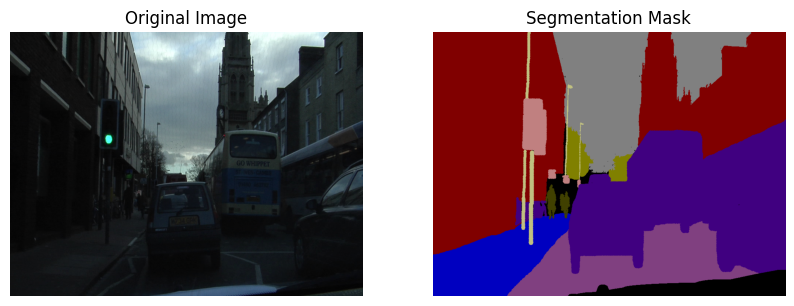

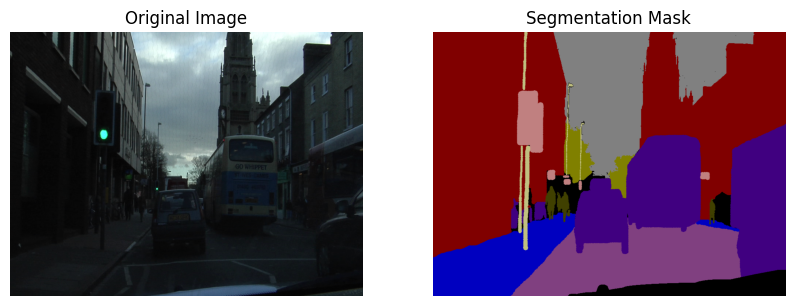

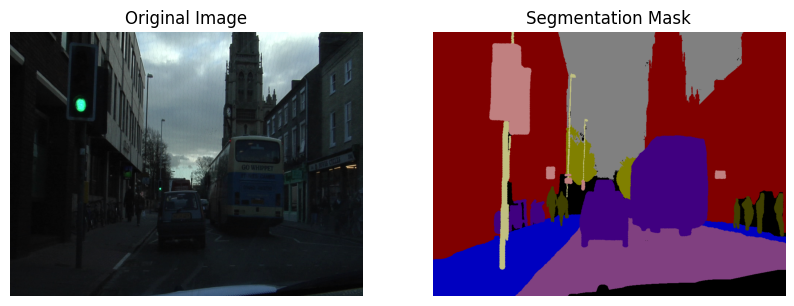

In [32]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_samples(num_samples=3):
    # Read the first `num_samples` from the training file
    with open('camvid_train.txt', 'r') as f:
        lines = [next(f) for _ in range(num_samples)]
    
    for idx, line in enumerate(lines):
        # Extract image and label paths
        img_path, label_path = line.strip().split()
        # Replace 'CamVidGray' with 'CamVidColor11' for color masks
        mask_path = label_path.replace('CamVidGray', 'CamVidColor11')
        
        # Load image and mask
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        
        # Plot
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title('Segmentation Mask')
        plt.axis('off')
        plt.show()

# Display sample images
display_samples()

In [33]:
# Depthwise Separable Convolution
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, 
                                  kernel_size=kernel_size, 
                                  stride=stride, 
                                  padding=padding, 
                                  groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                  kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Inverted Residual Block
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_dim = int(round(in_channels * expand_ratio))
        self.identity = stride == 1 and in_channels == out_channels

        self.conv = nn.Sequential(
            # Pointwise expansion
            nn.Conv2d(in_channels, hidden_dim, 1, 1, 0),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            # Depthwise convolution
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            # Pointwise projection
            nn.Conv2d(hidden_dim, out_channels, 1, 1, 0),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)

# Pyramid Pooling Module
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes):
        super(PyramidPooling, self).__init__()
        self.stages = nn.ModuleList()
        for pool_size in pool_sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, in_channels//4, kernel_size=1),
                nn.BatchNorm2d(in_channels//4),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Conv2d(in_channels + in_channels//4*len(pool_sizes), 
                                   in_channels, kernel_size=1)

    def forward(self, x):
        size = x.shape[2:]
        features = [x]
        for stage in self.stages:
            features.append(F.interpolate(stage(x), size=size, mode='bilinear'))
        out = torch.cat(features, dim=1)
        out = self.bottleneck(out)
        return out

# Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )
        
        self.stage1 = InvertedResidual(32, 48, 2, 6)
        self.stage2 = InvertedResidual(48, 64, 2, 6)
        
        self.stage3 = nn.Sequential(
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 96, 1, 6)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        return x

# Global Feature Extractor
class GlobalFeatureExtractor(nn.Module):
    def __init__(self):
        super(GlobalFeatureExtractor, self).__init__()
        self.high_level = nn.Sequential(
            InvertedResidual(96, 128, 2, 6),
            InvertedResidual(128, 128, 1, 6),
            InvertedResidual(128, 128, 1, 6),
            InvertedResidual(128, 160, 1, 6)
        )
        self.ppm = PyramidPooling(160, [1, 2, 3, 6])

    def forward(self, x):
        x = self.high_level(x)
        x = self.ppm(x)
        return x

# Feature Fusion Module
class FeatureFusion(nn.Module):
    def __init__(self):
        super(FeatureFusion, self).__init__()
        self.low_level_proj = nn.Sequential(
            nn.Conv2d(96, 48, 1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        
        self.fuse = nn.Sequential(
            SeparableConv2d(48 + 160, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )

    def forward(self, low_level, global_features):
        low_level = self.low_level_proj(low_level)
        global_features = F.interpolate(global_features, size=low_level.shape[2:], mode='bilinear')
        fused = torch.cat([low_level, global_features], dim=1)
        return self.fuse(fused)

# Classifier Head
class Classifier(nn.Module):
    def __init__(self, num_classes=12):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            SeparableConv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_classes, 1)
        )
        
    def forward(self, x):
        return self.classifier(x)

# Full Fast-SCNN Model
class FastSCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(FastSCNN, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.global_extractor = GlobalFeatureExtractor()
        self.feature_fusion = FeatureFusion()
        self.classifier = Classifier(num_classes)
        
    def forward(self, x):
        size = x.shape[2:]
        low_level = self.feature_extractor(x)
        global_features = self.global_extractor(low_level)
        fused = self.feature_fusion(low_level, global_features)
        logits = self.classifier(fused)
        return F.interpolate(logits, size=size, mode='bilinear')

# Model instantiation
model = FastSCNN(num_classes=12)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print model summary
summary(model, (3, 360, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 180, 240]             896
       BatchNorm2d-2         [-1, 32, 180, 240]              64
             ReLU6-3         [-1, 32, 180, 240]               0
            Conv2d-4        [-1, 192, 180, 240]           6,336
       BatchNorm2d-5        [-1, 192, 180, 240]             384
             ReLU6-6        [-1, 192, 180, 240]               0
            Conv2d-7         [-1, 192, 90, 120]           1,920
       BatchNorm2d-8         [-1, 192, 90, 120]             384
             ReLU6-9         [-1, 192, 90, 120]               0
           Conv2d-10          [-1, 48, 90, 120]           9,264
      BatchNorm2d-11          [-1, 48, 90, 120]              96
 InvertedResidual-12          [-1, 48, 90, 120]               0
           Conv2d-13         [-1, 288, 90, 120]          14,112
      BatchNorm2d-14         [-1, 288, 

In [34]:
# Verify FeatureExtractor output
def test_feature_extractor():
    x = torch.randn(2, 3, 360, 480)
    model = FeatureExtractor()
    out = model(x)
    if isinstance(out, tuple):
        out = out[0]

    print(f"FeatureExtractor output shape: {out.shape}")  # Expected: (2, 96, H, W)

# Run the test
test_feature_extractor()

FeatureExtractor output shape: torch.Size([2, 96, 45, 60])


In [38]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
import os
import time

# Fixed Dataset Class with shape consistency
class CamVidDataset(Dataset):
    def __init__(self, txt_file, transform=None, target_transform=None):
        with open(txt_file, 'r') as f:
            lines = f.readlines()
        self.image_paths = []
        self.mask_paths = []
        # Validate file paths first
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 2:
                continue  # Skip invalid lines
            img_path, mask_path = parts
            if os.path.exists(img_path) and os.path.exists(mask_path):
                self.image_paths.append(img_path)
                self.mask_paths.append(mask_path)
            else:
                print(f"Invalid pair: {img_path} {mask_path}")
                
        self.transform = transform
        self.target_transform = target_transform
        self.ignore_index = 255
        self.resize = transforms.Resize((240, 180))  # Central resize

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]
            
            # Load images
            image = Image.open(image_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')  # Grayscale mask
            
            # Ensure consistent resizing
            image = self.resize(image)
            mask = self.resize(mask)
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                mask = self.target_transform(mask)
                
            # Convert mask to tensor manually
            mask = torch.from_numpy(np.array(mask, dtype=np.int64))
            mask[mask == self.ignore_index] = 255
            
            return image, mask
            
        except Exception as e:
            print(f"Error at index {idx}: {str(e)}")
            # Return dummy with correct shapes
            return torch.zeros((3, 240, 180)), torch.zeros(240, 180, dtype=torch.long)

# Data Transforms with explicit normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets with path validation
train_dataset = CamVidDataset('camvid_train.txt', transform=transform)
val_dataset = CamVidDataset('camvid_val.txt', transform=transform)

# Fixed DataLoader configuration
batch_size = 16
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,  # Critical fix: Windows multiprocess issues
    pin_memory=True,
    drop_last=True  # Prevent shape mismatches
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

# Verify data loading
def verify_data():
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Val dataset size: {len(val_dataset)}")
    
    # Test first batch
    for images, masks in train_loader:
        print(f"Image shape: {images.shape}, Mask shape: {masks.shape}")
        print(f"Unique mask values: {torch.unique(masks)}")
        break

if __name__ == '__main__':
    verify_data()

Train dataset size: 367
Val dataset size: 101
Image shape: torch.Size([16, 3, 240, 180]), Mask shape: torch.Size([16, 240, 180])
Unique mask values: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152

In [51]:
# Dataset Class
class CamVidDataset(Dataset):
    def __init__(self, txt_file, transform=None, target_transform=None):
        with open(txt_file, 'r') as f:
            lines = f.readlines()
        self.image_paths = [line.strip().split()[0] for line in lines]
        self.mask_paths = [line.strip().split()[1] for line in lines]
        self.transform = transform
        self.target_transform = target_transform
        self.ignore_index = 255

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]

            image = Image.open(image_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')  # Assuming grayscale labels

            # Resize both image and mask
            resize_image = transforms.Resize((240, 180), interpolation=Image.BILINEAR)
            resize_mask = transforms.Resize((240, 180), interpolation=Image.NEAREST)

            image = resize_image(image)
            mask = resize_mask(mask)

            if self.transform:
                image = self.transform(image)

            # Convert mask to tensor manually
            mask = torch.from_numpy(np.array(mask, dtype=np.int64))

            # Apply ignore index
            mask[mask == self.ignore_index] = 255

            return image, mask

        except Exception as e:
            print(f"Error at index {idx}: {str(e)}")
            return torch.zeros((3, 240, 180)), torch.zeros(240, 180, dtype=torch.long)

# Data Transforms
transform = transforms.Compose([
    transforms.Resize((240, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and loaders
train_dataset = CamVidDataset('camvid_train.txt', transform=transform)
val_dataset = CamVidDataset('camvid_val.txt', transform=transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,pin_memory=True)

In [52]:
# Hyperparameters
num_epochs = 40
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.CrossEntropyLoss(ignore_index=255)

# Metric tracking
metrics = {
    'train_loss': [], 'val_loss': [],
    'val_iou': [], 'val_dice': []
}

In [53]:
def compute_metrics(preds, targets, num_classes=12, ignore_index=255):
    preds = preds.argmax(dim=1)
    valid_mask = targets != ignore_index
    
    preds = preds[valid_mask]
    targets = targets[valid_mask]
    
    # IoU calculation
    iou = []
    dice = []
    for cls in range(num_classes):
        if cls == 255:  # Skip ignore index
            continue
        pred_mask = preds == cls
        target_mask = targets == cls
        intersection = (pred_mask & target_mask).sum()
        union = (pred_mask | target_mask).sum()
        iou.append(intersection / (union + 1e-10))
        
        # Dice coefficient
        dice.append(2 * intersection / (pred_mask.sum() + target_mask.sum() + 1e-10))
    
    return torch.tensor(iou), torch.tensor(dice)

# Training loop with early stopping
best_iou = 0
patience = 7  # Number of epochs to wait after last improvement
early_stop_counter = 0
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    # Training phase
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    # Validation phase
    model.eval()
    val_loss = 0
    total_iou = 0
    total_dice = 0
    count = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            
            iou, dice = compute_metrics(outputs, masks)
            total_iou += iou.mean().item()
            total_dice += dice.mean().item()
            count += 1
    
    # Update metrics
    metrics['train_loss'].append(train_loss/len(train_loader))
    metrics['val_loss'].append(val_loss/len(val_loader))
    metrics['val_iou'].append(total_iou/count)
    metrics['val_dice'].append(total_dice/count)
    
    # Learning rate scheduling
    scheduler.step()
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs} | '
          f'Train Loss: {train_loss/len(train_loader):.4f} | '
          f'Val Loss: {val_loss/len(val_loader):.4f} | '
          f'IoU: {total_iou/count:.4f} | '
          f'Dice: {total_dice/count:.4f} | '
          f'Patience: {early_stop_counter}/{patience}')
    
    # Save best model and check early stopping
    current_iou = metrics['val_iou'][-1]
    if current_iou > best_iou:
        torch.save(model.state_dict(), 'best_model.pth')
        best_iou = current_iou
        early_stop_counter = 0  # Reset counter after improvement
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            print(f"Best Validation IoU: {best_iou:.4f}")
            break

print(f'\nTraining completed in {time.time()-start_time:.2f} seconds')

Epoch 1/100 | Train Loss: 21.3236 | Val Loss: 36.6991 | IoU: 0.0246 | Dice: 0.0379 | Patience: 0/10
Epoch 2/100 | Train Loss: 11.1591 | Val Loss: 11.0451 | IoU: 0.2958 | Dice: 0.3469 | Patience: 0/10
Epoch 3/100 | Train Loss: 9.0784 | Val Loss: 9.3228 | IoU: 0.3256 | Dice: 0.3755 | Patience: 0/10
Epoch 4/100 | Train Loss: 7.7377 | Val Loss: 8.0494 | IoU: 0.3543 | Dice: 0.3990 | Patience: 0/10
Epoch 5/100 | Train Loss: 7.0477 | Val Loss: 8.8583 | IoU: 0.3283 | Dice: 0.3819 | Patience: 0/10
Epoch 6/100 | Train Loss: 6.3602 | Val Loss: 7.6413 | IoU: 0.3563 | Dice: 0.3997 | Patience: 1/10
Epoch 7/100 | Train Loss: 5.9302 | Val Loss: 7.2472 | IoU: 0.3592 | Dice: 0.4040 | Patience: 0/10
Epoch 8/100 | Train Loss: 5.6994 | Val Loss: 7.2373 | IoU: 0.3608 | Dice: 0.4071 | Patience: 0/10
Epoch 9/100 | Train Loss: 5.2944 | Val Loss: 6.9853 | IoU: 0.3637 | Dice: 0.4094 | Patience: 0/10
Epoch 10/100 | Train Loss: 5.0329 | Val Loss: 6.9708 | IoU: 0.3691 | Dice: 0.4178 | Patience: 0/10
Epoch 11/100 | 

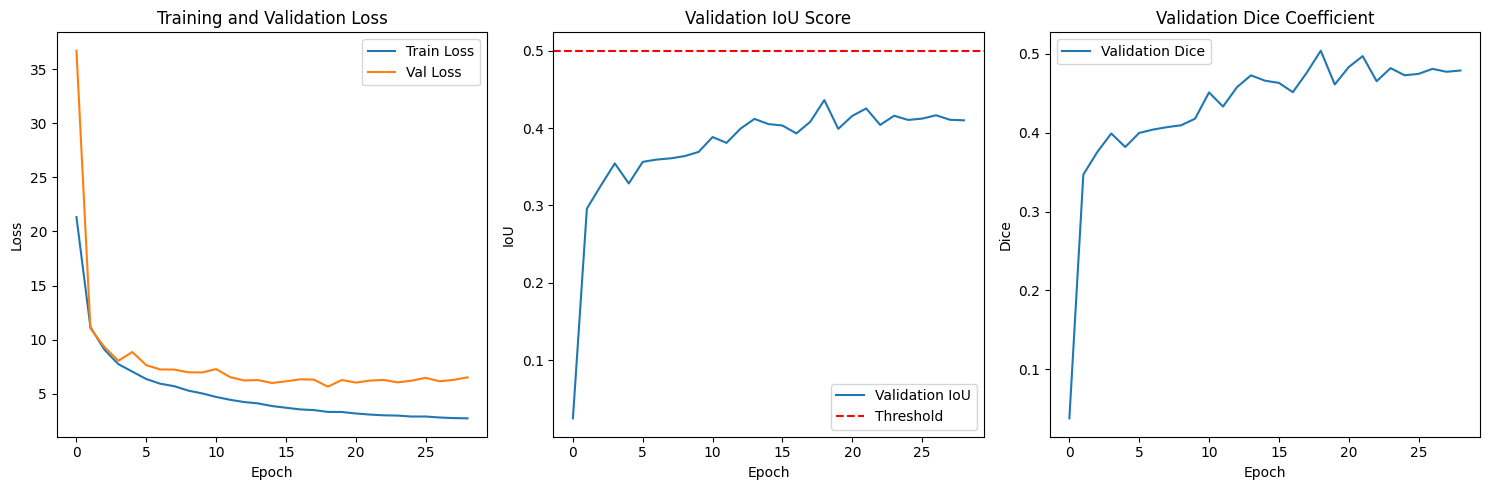

In [55]:
# Plotting function
def plot_metrics(metrics):
    plt.figure(figsize=(15, 5))
    
    # Loss curve
    plt.subplot(1, 3, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # IoU curve
    plt.subplot(1, 3, 2)
    plt.plot(metrics['val_iou'], label='Validation IoU')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold')
    plt.title('Validation IoU Score')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    # Dice curve
    plt.subplot(1, 3, 3)
    plt.plot(metrics['val_dice'], label='Validation Dice')
    plt.title('Validation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# Plot the metrics
plot_metrics(metrics)

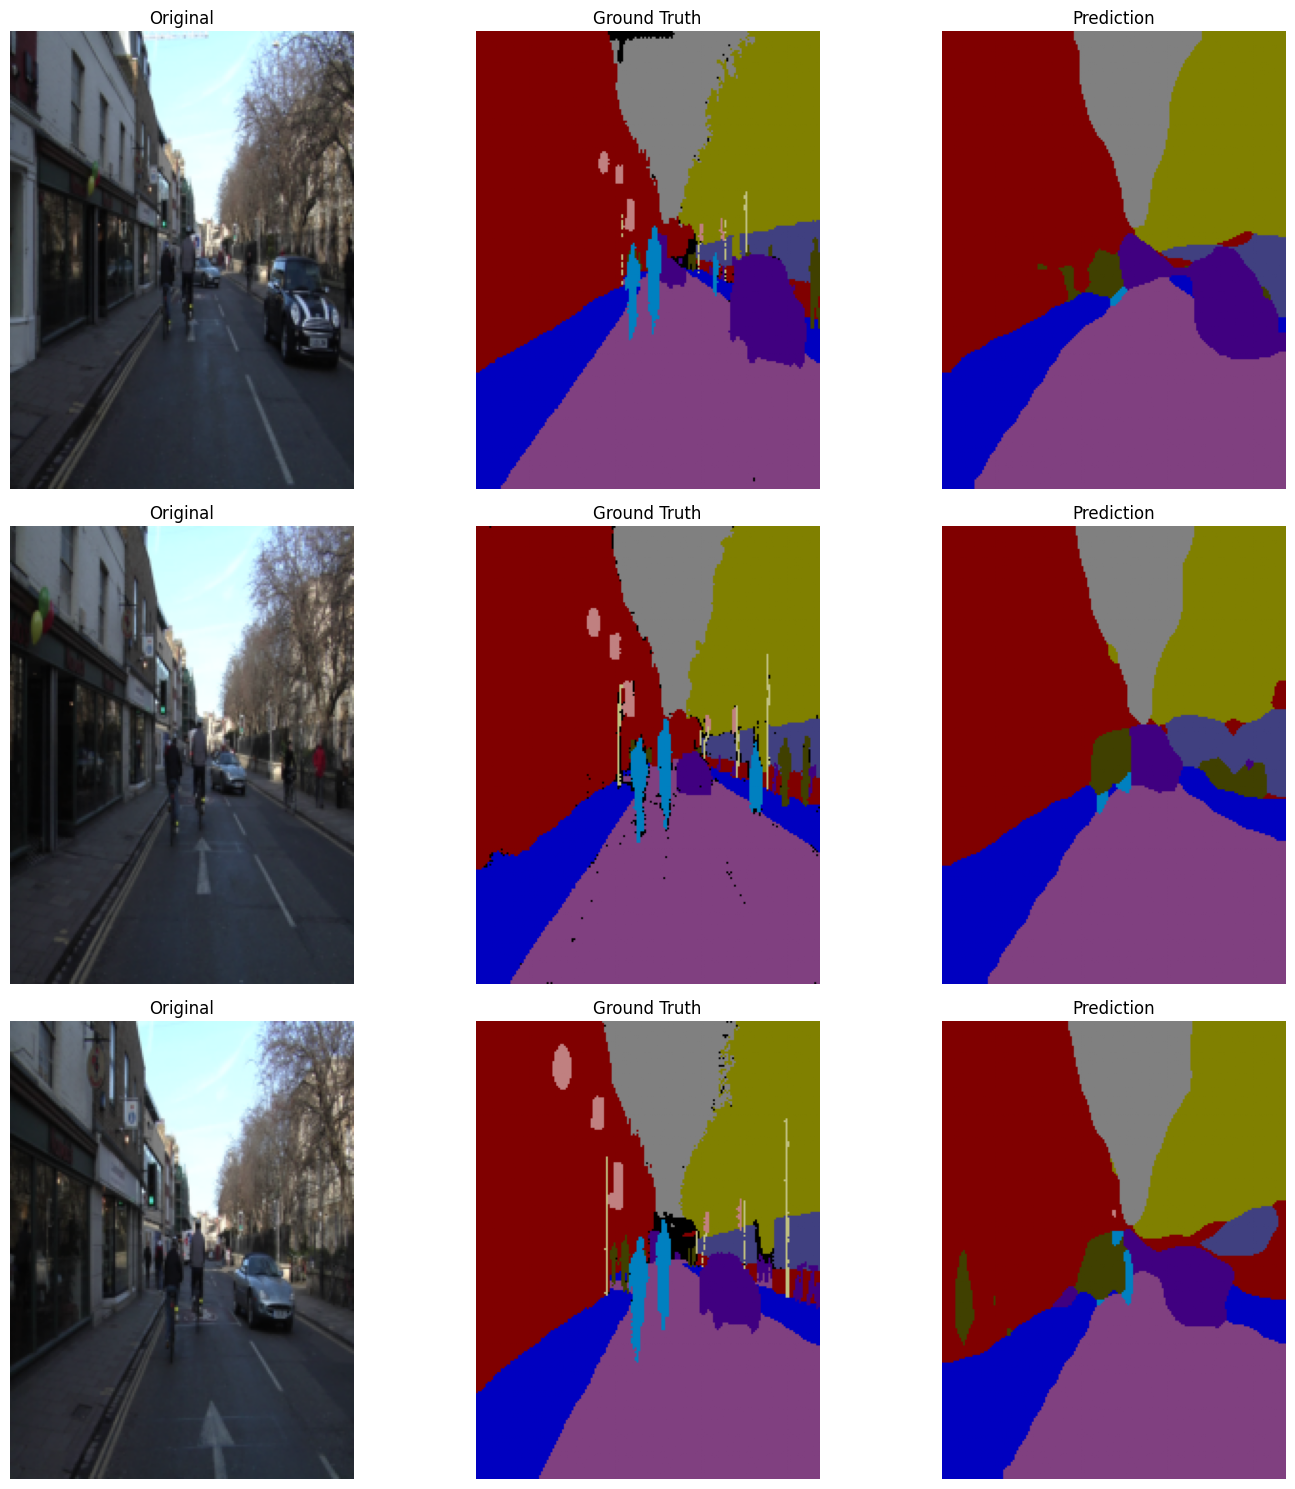

In [59]:
def visualize_predictions(model, dataloader, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    class_colors = np.array([
        [128, 128, 128],  # Sky
        [128, 0, 0],      # Building
        [192, 192, 128],  # Pole
        [128, 64, 128],   # Road
        [0, 0, 192],      # Sidewalk
        [128, 128, 0],    # Tree
        [192, 128, 128],  # SignSymbol
        [64, 64, 128],    # Fence
        [64, 0, 128],     # Car
        [64, 64, 0],      # Pedestrian
        [0, 128, 192],    # Bicyclist
        [0, 0, 0]         # Void (used for ignore)
    ]) / 255.0

    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            for j in range(3):  # Show 3 samples per batch
                img = images[j].cpu().numpy().transpose(1, 2, 0)
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                mask = masks[j].cpu().numpy()
                pred = preds[j].cpu().numpy()

                # Replace ignore index (255) with 11 ("Void") for visualization
                mask = np.where(mask == 255, 11, mask)

                axes[i, 0].imshow(img)
                axes[i, 0].set_title('Original')
                axes[i, 0].axis('off')

                axes[i, 1].imshow(class_colors[mask])
                axes[i, 1].set_title('Ground Truth')
                axes[i, 1].axis('off')

                axes[i, 2].imshow(class_colors[pred])
                axes[i, 2].set_title('Prediction')
                axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('segmentation_examples.png')
    plt.show()

# Visualize predictions
visualize_predictions(model, val_loader)

In [62]:
CAMVID_CLASSES = [
    'Sky', 'Building', 'Pole', 'Road', 
    'Sidewalk', 'Tree', 'SignSymbol', 'Fence', 
    'Car', 'Pedestrian', 'Bicyclist', 'Void'
]

In [63]:
# Final Evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

total_iou = 0
total_dice = 0
count = 0
confusion_matrix = np.zeros((12, 12))

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        iou, dice = compute_metrics(outputs, masks)
        total_iou += iou.mean().item()
        total_dice += dice.mean().item()
        count += 1
        
        # Update confusion matrix
        valid_mask = masks != 255
        preds = preds[valid_mask]
        masks = masks[valid_mask]
        for p, t in zip(preds.view(-1), masks.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

# Print final metrics
print(f'\nFinal Evaluation Results:')
print(f'Average IoU: {total_iou/count:.4f}')
print(f'Average Dice: {total_dice/count:.4f}')

# Compute class-wise IoU
class_iou = confusion_matrix.diagonal() / (
    confusion_matrix.sum(1) + confusion_matrix.sum(0) - confusion_matrix.diagonal()
)


valid_classes = CAMVID_CLASSES[:-1]  
valid_ious = class_iou[:-1]  
valid_ious = np.nan_to_num(valid_ious) 

print('\nClass-wise IoU (excluding Void):')
for name, iou_score in zip(valid_classes, valid_ious):
    print(f'{name}: {iou_score:.4f}')

print(f'\nMean IoU (excluding Void): {valid_ious.mean():.4f}')


Final Evaluation Results:
Average IoU: 0.4361
Average Dice: 0.5039

Class-wise IoU (excluding Void):
Sky: 0.9188
Building: 0.7848
Pole: 0.0000
Road: 0.9354
Sidewalk: 0.7570
Tree: 0.8640
SignSymbol: 0.0249
Fence: 0.4277
Car: 0.4322
Pedestrian: 0.1223
Bicyclist: 0.1134

Mean IoU (excluding Void): 0.4891


C:\Users\Ehsan\AppData\Local\Temp\ipykernel_3176\2888555283.py:34: RuntimeWarning: invalid value encountered in divide
  class_iou = confusion_matrix.diagonal() / (
